#================================
#CS 559 – Group 4 – Training Data
#================================

-------------------------------------
## 3.1 Train Data Process for Clustering
-------------------------------------

### Importing libraries and setting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import silhouette_score  # NEW

import joblib
import os

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")

### Load raw training data

In [2]:
df_raw = pd.read_csv("train_data.csv")
print(df_raw.shape)
df_raw.head()

(5807, 97)


,Index,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0,0,0.450397,0.504034,0.506986,0.594640,0.594640,0.998906,0.797293,0.809239,...,0.780554,0.004919,0.623634,0.594641,0.838869,0.279036,0.026788,0.565144,1,0.032464
1,1,0,0.530005,0.572885,0.574763,0.605695,0.605558,0.999058,0.797512,0.809399,...,0.819963,0.005968,0.624171,0.605690,0.841869,0.279040,0.026801,0.565205,1,0.032442
2,2,0,0.571150,0.620148,0.624177,0.612275,0.612282,0.999163,0.797654,0.809533,...,0.839128,0.006022,0.625306,0.612271,0.843294,0.278927,0.026816,0.565276,1,0.033034
3,3,0,0.483401,0.556694,0.536164,0.602445,0.602445,0.999035,0.797458,0.809380,...,0.806477,0.002177,0.621610,0.602444,0.841891,0.293391,0.027063,0.566190,1,0.015406
4,4,0,0.510359,0.537287,0.552546,0.600023,0.600023,0.999009,0.797406,0.809313,...,0.799277,0.001124,0.623993,0.600019,0.840313,0.279878,0.026880,0.565549,1,0.028858


### Cleaning & feature/target split

In [3]:
df = df_raw.copy()

target_col = "Bankrupt?"
y = df[target_col].astype(int)

drop_cols = ["Index", target_col]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]

print("Number of features:", len(feature_cols))
X.head()


Number of features: 95


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0.450397,0.504034,0.506986,0.594640,0.594640,0.998906,0.797293,0.809239,0.303489,0.781491,...,0.780554,0.004919,0.623634,0.594641,0.838869,0.279036,0.026788,0.565144,1,0.032464
1,0.530005,0.572885,0.574763,0.605695,0.605558,0.999058,0.797512,0.809399,0.303553,0.781665,...,0.819963,0.005968,0.624171,0.605690,0.841869,0.279040,0.026801,0.565205,1,0.032442
2,0.571150,0.620148,0.624177,0.612275,0.612282,0.999163,0.797654,0.809533,0.303582,0.781813,...,0.839128,0.006022,0.625306,0.612271,0.843294,0.278927,0.026816,0.565276,1,0.033034
3,0.483401,0.556694,0.536164,0.602445,0.602445,0.999035,0.797458,0.809380,0.303506,0.781633,...,0.806477,0.002177,0.621610,0.602444,0.841891,0.293391,0.027063,0.566190,1,0.015406
4,0.510359,0.537287,0.552546,0.600023,0.600023,0.999009,0.797406,0.809313,0.303468,0.781614,...,0.799277,0.001124,0.623993,0.600019,0.840313,0.279878,0.026880,0.565549,1,0.028858


### Bankruptcy Distribution Plot

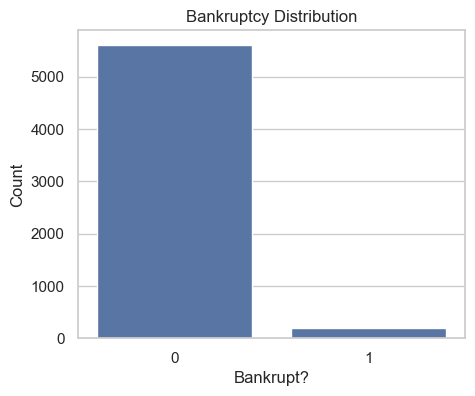

In [4]:
plt.figure(figsize=(5,4))
sns.countplot(x=df[target_col])
plt.title("Bankruptcy Distribution")
plt.xlabel("Bankrupt?")
plt.ylabel("Count")
plt.show()

### Correlation Heatmap (Top Features) EDA

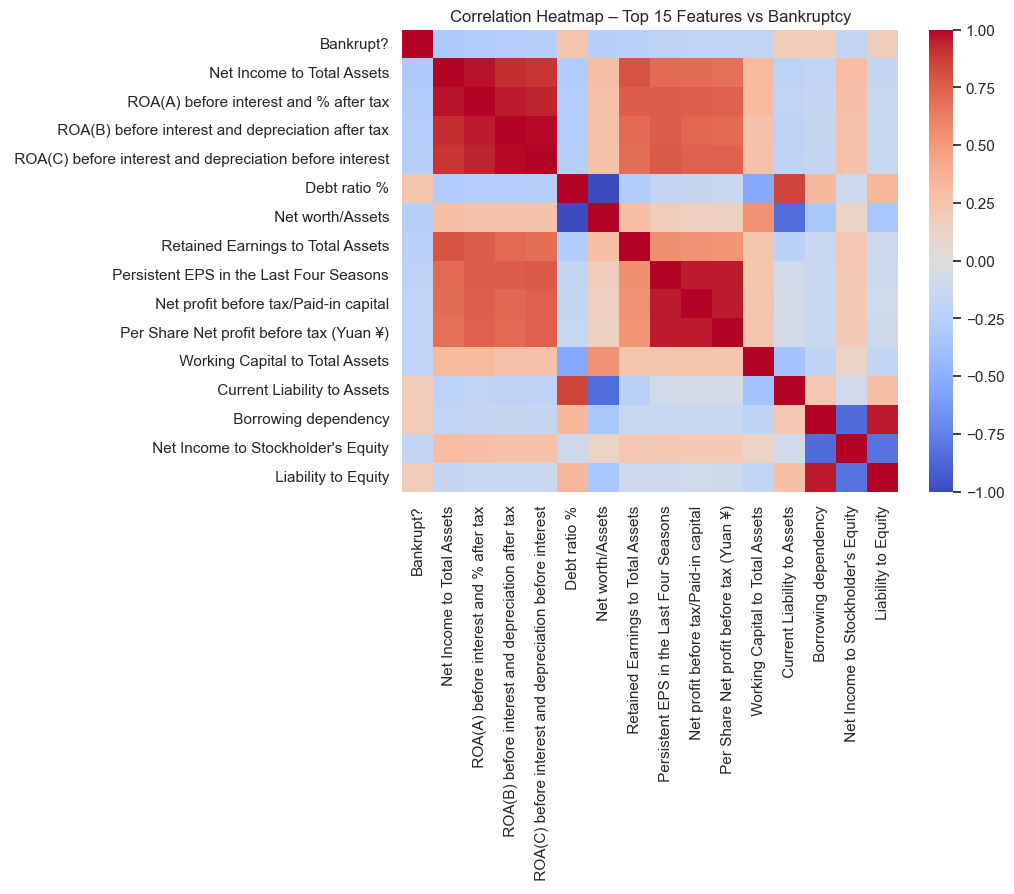

In [5]:
corr = df.drop(columns=["Index"]).corr()
top15 = corr[target_col].abs().sort_values(ascending=False).head(16).index

plt.figure(figsize=(8,6))
sns.heatmap(df[top15].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap – Top 15 Features vs Bankruptcy")
plt.show()

-------------------------------------
## PCA & Preprocessing (Still Section 3.1)
-------------------------------------

### Preprocessing object for clustering

In [6]:
N_COMPONENTS = 30

preprocess_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE))
])

X_clust = preprocess_pipeline.fit_transform(X)

print("Feature dimension after PCA:", X_clust.shape)

Feature dimension after PCA: (5807, 30)


### PCA Explained Variance Plot

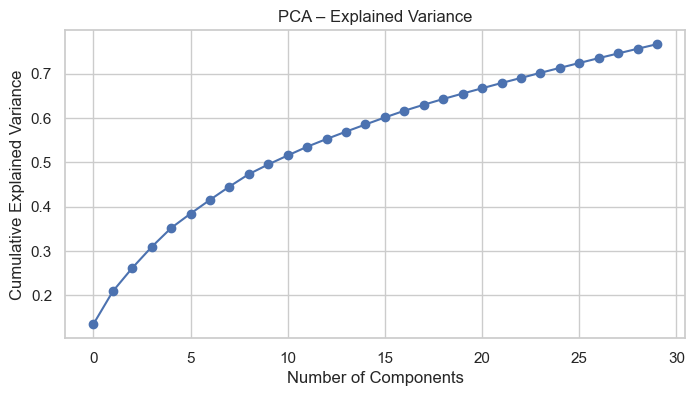

In [7]:
pca = preprocess_pipeline.named_steps["pca"]

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA – Explained Variance")
plt.grid(True)
plt.show()

### Choosing the Number of Clusters – Elbow Method

To justify the choice of **k = 6** clusters, we compute the K-Means inertia
(sum of squared distances to the nearest cluster center) for different values
of k and look for an "elbow" in the curve.


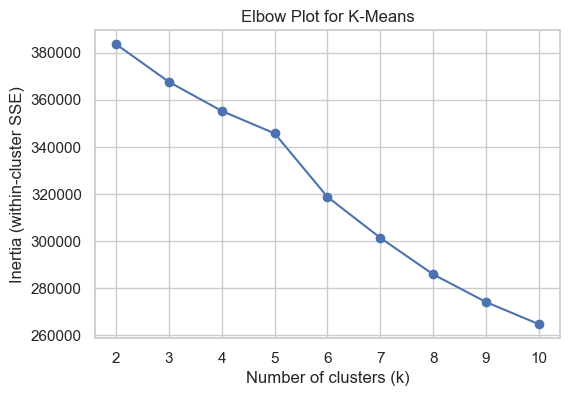

In [8]:
# Elbow plot using the preprocessed features (X_clust)

k_values = range(2, 11)
inertias = []

for k in k_values:
    km = KMeans(
        n_clusters=k,
        random_state=RANDOM_STATE,
        n_init="auto"
    )
    km.fit(X_clust)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Plot for K-Means")
plt.grid(True)
plt.show()

### Silhouette Scores for Different k

We also compute the **silhouette score** for different values of k.
Higher silhouette scores indicate better-separated, more coherent clusters.
This gives an additional check that **k = 4** is a reasonable choice.


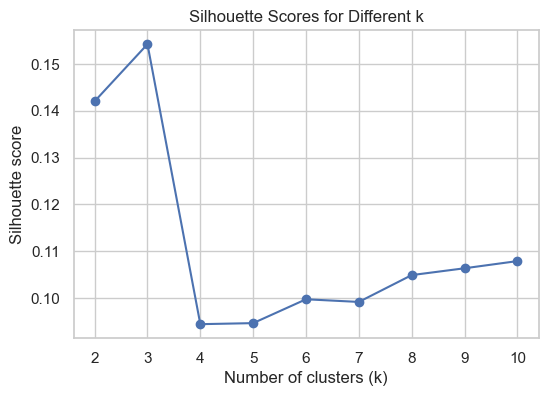

,k,silhouette_score
0,2,0.142015
1,3,0.154196
2,4,0.094469
3,5,0.094691
4,6,0.099779
5,7,0.099213
6,8,0.104935
7,9,0.106392
8,10,0.107924


In [9]:
sil_scores = []

for k in k_values:
    km = KMeans(
        n_clusters=k,
        random_state=RANDOM_STATE,
        n_init="auto"
    )
    labels_k = km.fit_predict(X_clust)
    sil = silhouette_score(X_clust, labels_k)
    sil_scores.append(sil)

plt.figure(figsize=(6, 4))
plt.plot(k_values, sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Scores for Different k")
plt.grid(True)
plt.show()

# Optional: show the scores in a small table
pd.DataFrame({
    "k": list(k_values),
    "silhouette_score": sil_scores
})

### Save preprocessing object

In [10]:
os.makedirs("models", exist_ok=True)

preprocess_obj = {
    "feature_cols": feature_cols,
    "pipeline": preprocess_pipeline
}

joblib.dump(preprocess_obj, "models/preprocessing_clustering.joblib")

print("Saved: models/preprocessing_clustering.joblib")

Saved: models/preprocessing_clustering.joblib


--------------------------------------------
## 3.2 Company Characterization (Clustering)
--------------------------------------------

### Running K-Means with k=6 clusters

In [11]:
K = 6  

kmeans = KMeans(
    n_clusters=K,
    random_state=RANDOM_STATE,
    n_init="auto"
)

cluster_labels = kmeans.fit_predict(X_clust)

df["cluster_id"] = cluster_labels

df[["Index", "Bankrupt?", "cluster_id"]].head()

,Index,Bankrupt?,cluster_id
0,0,0,3
1,1,0,2
2,2,0,2
3,3,0,0
4,4,0,0


### 2D PCA scatter plot with cluster colors

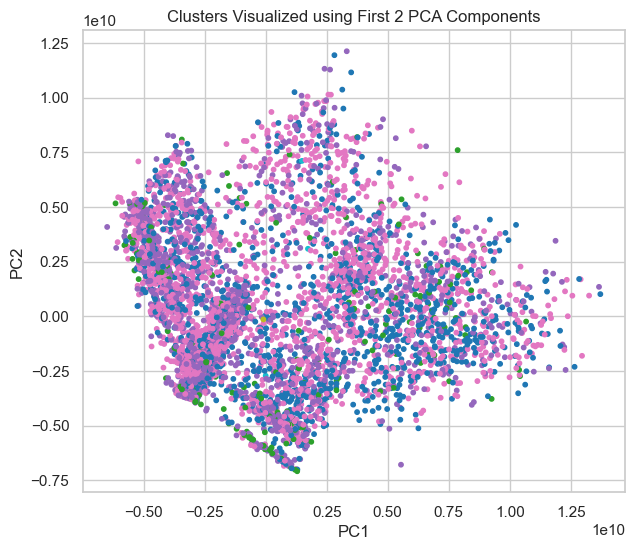

In [12]:
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca_2.fit_transform(X)

plt.figure(figsize=(7,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=df["cluster_id"], cmap="tab10", s=10)
plt.title("Clusters Visualized using First 2 PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Cluster characterization table

In [13]:
cluster_summary = (
    df.groupby("cluster_id")
      .agg(
          N_total=("Bankrupt?", "size"),
          N_bankrupt=("Bankrupt?", "sum")
      )
      .reset_index()
)

cluster_summary["bankrupt_rate"] = (
    cluster_summary["N_bankrupt"] / cluster_summary["N_total"]
)

print("\n============================")
print("CLUSTER SUMMARY - FINAL")
print("============================")
cluster_summary


CLUSTER SUMMARY - FINAL


,cluster_id,N_total,N_bankrupt,bankrupt_rate
0,0,1345,109,0.081041
1,1,324,0,0.000000
2,2,1976,4,0.002024
3,3,2157,82,0.038016
4,4,2,0,0.000000
5,5,3,3,1.000000


### Bar chart – bankruptcy rate per cluster

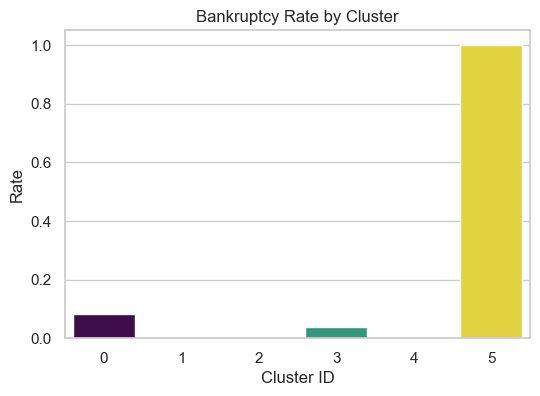

In [14]:
plt.figure(figsize=(6,4))
sns.barplot(
    x="cluster_id",
    y="bankrupt_rate",
    hue="cluster_id",
    data=cluster_summary,
    palette="viridis",
    legend=False
)
plt.title("Bankruptcy Rate by Cluster")
plt.ylabel("Rate")
plt.xlabel("Cluster ID")
plt.show()

### Bar chart – cluster sizes

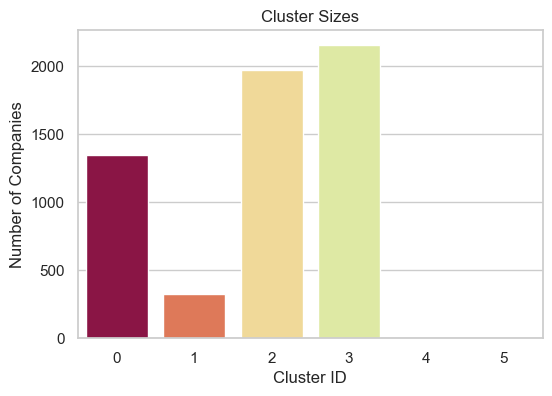

In [15]:
plt.figure(figsize=(6,4))
sns.barplot(
    x="cluster_id",
    y="N_total",
    hue="cluster_id",
    data=cluster_summary,
    palette="Spectral",
    legend=False
)
plt.title("Cluster Sizes")
plt.ylabel("Number of Companies")
plt.xlabel("Cluster ID")
plt.show()

### Save Clustered Data & Per-Cluster CSVs

In [16]:
os.makedirs("data", exist_ok=True)

df.to_csv("data/train_with_clusters.csv", index=False)

for cid in sorted(df["cluster_id"].unique()):
    out_path = f"data/train_cluster{cid}.csv"
    df[df["cluster_id"] == cid].to_csv(out_path, index=False)
    print(f"Saved {out_path}")

cluster_summary

Saved data/train_cluster0.csv
Saved data/train_cluster1.csv
Saved data/train_cluster2.csv
Saved data/train_cluster3.csv
Saved data/train_cluster4.csv
Saved data/train_cluster5.csv


,cluster_id,N_total,N_bankrupt,bankrupt_rate
0,0,1345,109,0.081041
1,1,324,0,0.000000
2,2,1976,4,0.002024
3,3,2157,82,0.038016
4,4,2,0,0.000000
5,5,3,3,1.000000


In [17]:
print("\n================ CLUSTER CHARACTERISTICS SUMMARY ================")
print("Required interpretation for presentation + Results.docx\n")

for c in sorted(df.cluster_id.unique()):
    sub = df[df.cluster_id==c].drop(columns=["Index","Bankrupt?"])
    print(f"\nCluster {c} — Top feature means:")
    print(sub.mean().sort_values(ascending=False).head(7))
    print("Interpretation: These features dominate this cluster. Useful for Stage-2 model.\n")


================ CLUSTER CHARACTERISTICS SUMMARY ================
Required interpretation for presentation + Results.docx


Cluster 0 — Top feature means:
Total Asset Growth Rate                  5.137117e+09
Cash Turnover Rate                       2.937776e+09
Quick Asset Turnover Rate                2.916281e+09
Operating Expense Rate                   2.601364e+09
Inventory Turnover Rate (times)          1.776600e+09
Current Asset Turnover Rate              1.585969e+09
Research and development expense rate    1.530328e+09
dtype: float64
Interpretation: These features dominate this cluster. Useful for Stage-2 model.


Cluster 1 — Top feature means:
Total Asset Growth Rate                  3.969293e+09
Research and development expense rate    2.452634e+09
Operating Expense Rate                   2.121481e+09
Inventory Turnover Rate (times)          1.699469e+09
Quick Asset Turnover Rate                1.511731e+09
Cash Turnover Rate                       1.405506e+09
Current Asset 

-------------------------------------
## 3.3.1 Cluster-ID Prediction
-------------------------------------

### Prepare Data for Cluster-ID Classifier

In [18]:
X_cluster_clf = df[feature_cols].copy()
y_cluster_clf = df["cluster_id"].astype(int)

print(X_cluster_clf.shape, y_cluster_clf.shape)

(5807, 95) (5807,)


### Random Forest classifier pipeline

In [19]:
cluster_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

### Train/test split & evaluation

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X_cluster_clf,
    y_cluster_clf,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=None
)

cluster_clf.fit(X_train, y_train)

val_acc = cluster_clf.score(X_val, y_val)
print("Validation accuracy:", round(val_acc, 3))

Validation accuracy: 0.919


### 5-fold CV accuracy

In [21]:
cv_scores = cross_val_score(
    cluster_clf,
    X_cluster_clf,
    y_cluster_clf,
    cv=5,
    n_jobs=-1
)

print("CV scores:", cv_scores)
print("Mean CV accuracy:", round(cv_scores.mean(), 3))

c:\Users\parth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


CV scores: [0.93459552 0.91566265 0.90525409 0.92420327 0.91989664]
Mean CV accuracy: 0.92


### Save cluster-ID model

In [22]:
cluster_id_model_obj = {
    "feature_cols": feature_cols,
    "model": cluster_clf
}

joblib.dump(cluster_id_model_obj, "models/cluster_id_model.joblib")

print("Saved: models/cluster_id_model.joblib")

Saved: models/cluster_id_model.joblib


-------------------------------------
## 3.4 Summary of Training Data Processing

In this notebook, we:

- Loaded the original training data (`train_data.csv`) and inspected basic properties.
- Separated the **target** (`Bankrupt?`) from the **feature set** and removed the `Index` column.
- Built a preprocessing pipeline that:
  - Standardizes all features.
  - Applies **PCA** (30 components) to reduce dimensionality while preserving most variance.
- Used the **Elbow Method** and **Silhouette scores** to justify choosing **k = 6** clusters.
- Ran **K-Means (k = 6)** on the preprocessed features and assigned each company a `cluster_id`.
- Visualized clusters using a 2D PCA scatter plot and summarized:
  - Cluster sizes (`N_total`)
  - Bankruptcy counts and rates (`N_bankrupt`, `bankrupt_rate`)
- Saved:
  - `data/train_with_clusters.csv` – full dataset with cluster labels.
  - `data/train_cluster0.csv` … `data/train_cluster5.csv` – one CSV per cluster, to be used by each subgroup.
- Trained a **RandomForest classifier** to predict `cluster_id` from the original features and:
  - Evaluated it using validation split and 5-fold cross-validation.
  - Saved the preprocessing and model objects:
    - `models/preprocessing_clustering.joblib`
    - `models/cluster_id_model.joblib`

These artifacts are now used downstream by the four subgroup notebooks to build
cluster-specific bankruptcy prediction models and stacking ensembles.
